In [63]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
#import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
#import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
import tf_keras as keras  # Use tf_keras instead of tf.keras
from tf_keras import layers
from tf_keras.models import Model, Sequential
from tf_keras.layers import Input, Dropout, Dense
from tf_keras.optimizers import Adam
import tensorflow_probability as tfp
import tensorflow_probability.python.layers as tfpl
tfd = tfp.distributions
from tf_keras.callbacks import CSVLogger

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm



In [5]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [6]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    vals = [[] for _ in range(n_inputs)]


# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        for i in range(n_inputs):
            tmp = data.sel(x=lon, y=lat, band=i, method='nearest').values
            vals[i].append(tmp)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    for i in range(n_inputs):
        df[names[i]] = vals[i]
    
    return df


In [100]:
# Constants
n_inputs = 28
names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "ndwi", "ndvi", "ndbi", 
        "B01 (pooled)", "B02 (pooled)", "B03 (pooled)", "B04 (pooled)", "B05 (pooled)", "B06 (pooled)", "B07 (pooled)", "B08 (pooled)", "B8A (pooled)", "B11 (pooled)", "B12 (pooled)", "ndwi (pooled)", "ndvi (pooled)", "ndbi (pooled)"]
UhiData_FileName = "Data/Training_data_uhi_index.csv"
satellite_data =  "Data/S2_median_fullBands_indeces.tiff"
test_size = 0.3

# Open the GeoTIFF file
tiff_path = "Data/S2_median_fullBands_indeces.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    cols = [src1.read(i) for i in range(1, n_inputs+1)]


In [8]:
# Would be faster in a df
feature_data = map_satellite_data(satellite_data, UhiData_FileName)

Mapping values: 100%|██████████| 11229/11229 [10:38<00:00, 17.58it/s]


In [9]:
# Redo columns
feature_data["ndwi"] = (feature_data["B03"] - feature_data["B08"])/(feature_data["B03"] + feature_data["B08"]) #Normalized Difference Water Index
feature_data["ndbi"] = (feature_data["B11"] - feature_data["B08"])/(feature_data["B11"] + feature_data["B08"]) # Normalized Difference Buildup Index
feature_data["ndvi"] = (feature_data["B08"] - feature_data["B04"])/(feature_data["B08"] + feature_data["B04"]) #Normalized Difference Vegetation Index
feature_data["ndwi (pooled)"] = (feature_data["B03 (pooled)"] - feature_data["B08 (pooled)"])/(feature_data["B03 (pooled)"] + feature_data["B08 (pooled)"]) #Normalized Difference Water Index
feature_data["ndbi (pooled)"] = (feature_data["B11 (pooled)"] - feature_data["B08 (pooled)"])/(feature_data["B11 (pooled)"] + feature_data["B08 (pooled)"]) # Normalized Difference Buildup Index
feature_data["ndvi (pooled)"] = (feature_data["B08 (pooled)"] - feature_data["B04 (pooled)"])/(feature_data["B08 (pooled)"] + feature_data["B04 (pooled)"]) #Normalized Difference Vegetation Index

feature_data['ndvi'] = feature_data['ndvi'].replace([np.inf, -np.inf], np.nan) 
feature_data['ndwi'] = feature_data['ndwi'].replace([np.inf, -np.inf], np.nan) 
feature_data['ndbi'] = feature_data['ndbi'].replace([np.inf, -np.inf], np.nan)
feature_data['ndvi (pooled)'] = feature_data['ndvi (pooled)'].replace([np.inf, -np.inf], np.nan) 
feature_data['ndwi (pooled)'] = feature_data['ndwi (pooled)'].replace([np.inf, -np.inf], np.nan) 
feature_data['ndbi (pooled)'] = feature_data['ndbi (pooled)'].replace([np.inf, -np.inf], np.nan) 

In [10]:
# Combining ground data and feature data into a single dataset.
ground_df = pd.read_csv(UhiData_FileName)
uhi_data = combine_two_datasets(ground_df,feature_data)

In [11]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01','B04','B06','B08','ndvi']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B02,B03,B04,B05,B06,...,B05 (pooled),B06 (pooled),B07 (pooled),B08 (pooled),B8A (pooled),B11 (pooled),B12 (pooled),ndwi (pooled),ndvi (pooled),ndbi (pooled)
0,-73.909167,40.813107,24-07-2021 15:53,1.030289,841.5,841.5,1053.0,1155.0,1206.0,1481.5,...,1220.8703703703707,1428.3641975308642,1753.5802469135792,1869.7654320987654,1814.5370370370372,1927.7037037037044,1841.3209876543203,-0.308904,0.247049,0.015257
2,-73.909215,40.812978,24-07-2021 15:53,1.023798,841.5,841.5,646.0,823.0,777.0,1130.5,...,1134.7777777777778,1396.148148148148,1812.469135802468,1948.9567901234568,1876.382716049383,2021.0740740740753,1793.4320987654314,-0.354534,0.292568,0.018165
3,-73.909242,40.812908,24-07-2021 15:53,1.023798,841.5,841.5,625.0,766.0,741.5,1130.5,...,1165.3765432098771,1413.3148148148139,1846.5679012345677,1988.7777777777778,1953.9691358024688,2069.808641975309,1796.4876543209875,-0.344815,0.284392,0.019965
4,-73.909257,40.812845,24-07-2021 15:53,1.021634,841.5,841.5,659.5,763.0,708.5,1077.5,...,1197.7777777777776,1426.7469135802453,1871.851851851852,2020.4691358024688,2023.9629629629626,2102.641975308642,1816.3395061728395,-0.331936,0.272227,0.019930
6,-73.909312,40.812710,24-07-2021 15:53,1.015143,841.5,841.5,551.5,768.5,659.0,1077.5,...,1082.1975308641972,1356.6790123456778,1823.4012345679012,1985.0925925925926,1991.2037037037037,2068.808641975308,1777.5370370370372,-0.361310,0.300358,0.020651


In [12]:
# Load data, normalize distributions
model1_data = uhi_data[names + ['UHI Index']]
md1_data_std = model1_data.apply(lambda x: (x - x.mean()) / x.std(), axis=0) 
md1_data_std =md1_data_std.apply(lambda x: pd.to_numeric(x, errors = 'coerce'), axis=0) 

In [101]:
# Divide data into training and testing
X = md1_data_std.drop(columns=['UHI Index']).values
y = md1_data_std['UHI Index'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=123)
print(X_train.shape) 
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5848, 28)
(5848,)
(2507, 28)
(2507,)


In [102]:
def test_model(model, X_test, y_test):
    print(f"MSE: {mean_squared_error(y_test , model.predict(X_test))}")
    print(f"r2: {r2_score(y_test, model.predict(X_test))}")
    y_lazy_pred = np.mean(y_test)*np.ones(len(y_test))
    print(f'Lazy MSE: {mean_squared_error(y_test , y_lazy_pred)}')
    print(f"Lazy r2: {r2_score(y_test, y_lazy_pred)}")

In [155]:
# Standard Model
model1 = Sequential([
    Dense(32, activation = 'relu', input_shape=(28,) ),
    Dropout(0.1),
    Dense(32, activation = 'relu'),
    Dropout(0.1),
    Dense(1, activation = 'linear'),
])
model1.compile(optimizer=Adam(learning_rate=0.001) , loss = "MSE" )
log = CSVLogger(f"Model_Stats/standard_training.log", append=True)
model1.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[log])

Epoch 1/50
165/165 [==============================] - 2s 5ms/step - loss: 0.9980 - val_loss: 0.9007
Epoch 2/50
165/165 [==============================] - 1s 4ms/step - loss: 0.8732 - val_loss: 0.8899
Epoch 3/50
165/165 [==============================] - 1s 4ms/step - loss: 0.8623 - val_loss: 0.8749
Epoch 4/50
165/165 [==============================] - 1s 6ms/step - loss: 0.8477 - val_loss: 0.8706
Epoch 5/50
165/165 [==============================] - 1s 5ms/step - loss: 0.8358 - val_loss: 0.8615
Epoch 6/50
165/165 [==============================] - 1s 4ms/step - loss: 0.8359 - val_loss: 0.8792
Epoch 7/50
165/165 [==============================] - 1s 5ms/step - loss: 0.8356 - val_loss: 0.8525
Epoch 8/50
165/165 [==============================] - 1s 5ms/step - loss: 0.8209 - val_loss: 0.8492
Epoch 9/50
165/165 [==============================] - 1s 7ms/step - loss: 0.8156 - val_loss: 0.8379
Epoch 10/50
165/165 [==============================] - 1s 5ms/step - loss: 0.8126 - val_loss: 0.8415

79/79 [==============================] - 0s 3ms/step
MSE: 0.7919905143089316
79/79 [==============================] - 0s 4ms/step
r2: 0.20935918311177915
Lazy MSE: 1.0017070930211052
Lazy r2: 0.0


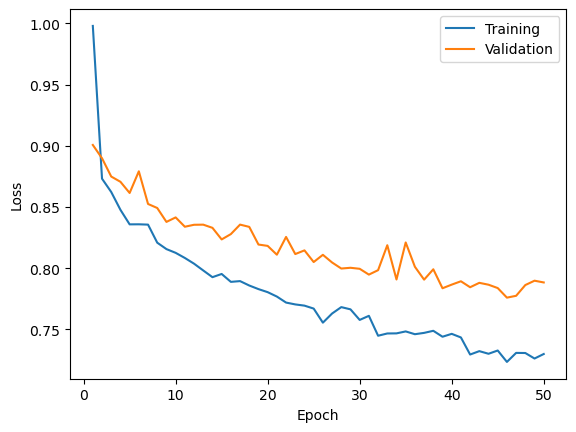

In [156]:
test_model(model1, X_test=X_test, y_test=y_test)
log = pd.read_csv(f"Model_Stats/standard_training.log")
training_loss = log["loss"]
validation_loss = log["val_loss"]
plt.plot(np.arange(1, len(training_loss) + 1), training_loss, label="Training")
plt.plot(np.arange(1, len(validation_loss) + 1), validation_loss, label="Validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [147]:
# Fixed prior: standard normal, wrapped in Independent
def prior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.Independent(
                tfd.Normal(loc=tf.zeros(n), scale=1.0),
                #tfd.Laplace(loc=tf.zeros(n), scale=1.0),
                #tfd.StudentT(df=3.0, loc=tf.zeros(n), scale=1.0),
                reinterpreted_batch_ndims=1)
        )
    ])

# Posterior: learnable multivariate Gaussian
def posterior(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])

In [157]:
# Bayesian Model
inputs = Input(shape=(28,))
x = tfp.layers.DenseVariational(
    units=16,
    make_prior_fn=prior,
    make_posterior_fn=posterior,
    kl_weight = 1e-6,
    activation='sigmoid')(inputs)
outputs = Dense(1, activation='linear')(x)

model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=Adam(0.001), loss="mse")
log = CSVLogger(f"Model_Stats/bnn_training.log", append=True)
model2.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[log])

Epoch 1/50
165/165 [==============================] - 4s 10ms/step - loss: 1.2907 - val_loss: 1.2241
Epoch 2/50
165/165 [==============================] - 1s 8ms/step - loss: 1.1230 - val_loss: 1.1190
Epoch 3/50
165/165 [==============================] - 1s 8ms/step - loss: 1.0475 - val_loss: 1.0362
Epoch 4/50
165/165 [==============================] - 1s 7ms/step - loss: 1.0120 - val_loss: 1.0731
Epoch 5/50
165/165 [==============================] - 1s 7ms/step - loss: 0.9818 - val_loss: 1.0021
Epoch 6/50
165/165 [==============================] - 1s 8ms/step - loss: 0.9511 - val_loss: 1.0115
Epoch 7/50
165/165 [==============================] - 1s 8ms/step - loss: 0.9421 - val_loss: 0.9619
Epoch 8/50
165/165 [==============================] - 1s 7ms/step - loss: 0.9237 - val_loss: 0.9755
Epoch 9/50
165/165 [==============================] - 1s 7ms/step - loss: 0.9279 - val_loss: 0.9711
Epoch 10/50
165/165 [==============================] - 1s 7ms/step - loss: 0.9258 - val_loss: 0.957

79/79 [==============================] - 1s 6ms/step
MSE: 0.9191539855575305
79/79 [==============================] - 0s 3ms/step
r2: 0.08472361658436589
Lazy MSE: 1.0017070930211052
Lazy r2: 0.0


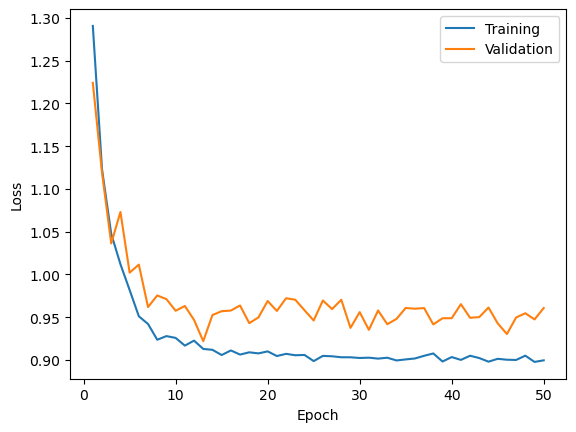

In [158]:
test_model(model2, X_test=X_test, y_test=y_test)
log = pd.read_csv(f"Model_Stats/bnn_training.log")
training_loss = log["loss"]
validation_loss = log["val_loss"]
plt.plot(np.arange(1, len(training_loss) + 1), training_loss, label="Training")
plt.plot(np.arange(1, len(validation_loss) + 1), validation_loss, label="Validation")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()